In [1]:
#import cupy as cp
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import numpy as np
from wikipedia2vec import Wikipedia2Vec

np.random.seed(1)
vectorDim = 100

numNode = 100

inputDataTraining = np.load('./trainingData_averaging/inputDataTraining_4k_average.npy')
outputDataTraining = np.load('./trainingData_averaging/outputDataTraining_4k_average.npy')



Using Numpy backend.


In [2]:
esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
#esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

In [3]:
# this is the reservoir training, allow it a minute or two to complete
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)

100% (1526210 of 1526210) |##############| Elapsed Time: 0:00:56 Time:  0:00:56


0.06841102701840343

In [4]:
wiki2vec = Wikipedia2Vec.load('enwiki_20180420_100d.pkl')

#discourse_words = ['peanut', 'woman', 'saw', 'dancing', 'peanut', 'big', 'smile', 'his', 'face', 'peanut', 'singing', 'girl', 'just', 'met', 'judging', 'song', 'peanut', 'totally', 'crazy', 'her', 'woman', 'thought', 'really', 'cute', 'see', 'peanut', 'singing', 'dancing', 'peanut']
discourse_words = ['peanuts', 'snacks', 'bowl', 'bar', 'people', 'eating', 'chips', 'drinking', 'beer', 'watching', 'football', 'game', 'woman', 'saw', 'dancing', 'peanut', 'big', 'smile', 'his', 'face', 'peanut', 'singing', 'girl', 'just', 'met', 'judging', 'song', 'peanut', 'totally', 'crazy', 'her', 'woman', 'thought', 'really', 'cute', 'see', 'peanut', 'singing', 'dancing', 'peanut']
print(discourse_words)

['peanuts', 'snacks', 'bowl', 'bar', 'people', 'eating', 'chips', 'drinking', 'beer', 'watching', 'football', 'game', 'woman', 'saw', 'dancing', 'peanut', 'big', 'smile', 'his', 'face', 'peanut', 'singing', 'girl', 'just', 'met', 'judging', 'song', 'peanut', 'totally', 'crazy', 'her', 'woman', 'thought', 'really', 'cute', 'see', 'peanut', 'singing', 'dancing', 'peanut']


In [5]:
inputDataTesting = np.empty((0,vectorDim))
print(inputDataTesting.shape)

for num in range(len(discourse_words)):
    inputDataTesting = np.append(inputDataTesting, np.array([wiki2vec.get_word_vector(discourse_words[num])]), axis=0)
print(inputDataTesting.shape)

(0, 100)
(40, 100)


In [8]:
prediction = esn.predict(inputDataTesting)
#print(prediction)


In [9]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


accuracy_trajectory = np.array([])

for num in range(len(discourse_words)):
    #print(discourse_words[num])
    if num == 0:
        discourse_vector4trajectory = wiki2vec.get_word_vector(discourse_words[num])
    else:
        discourse_vector4trajectory = (num * discourse_vector4trajectory + wiki2vec.get_word_vector(discourse_words[num])) / (num + 1)
    accuracy_trajectory = np.append(accuracy_trajectory, cos_sim(discourse_vector4trajectory, prediction[num]))
print(accuracy_trajectory)

[0.57851908 0.66425371 0.72951539 0.76468353 0.79772415 0.84062296
 0.85539531 0.86801684 0.88030313 0.88047699 0.87954655 0.89149036
 0.89954159 0.89976375 0.90571927 0.91770126 0.9174908  0.91113495
 0.90213749 0.90415279 0.92365104 0.91640751 0.91241582 0.90644827
 0.90358012 0.90317002 0.90290133 0.92376863 0.90945512 0.91698872
 0.90751064 0.90720859 0.90047998 0.90559771 0.90928692 0.90079037
 0.92990363 0.9290571  0.92978741 0.94388407]


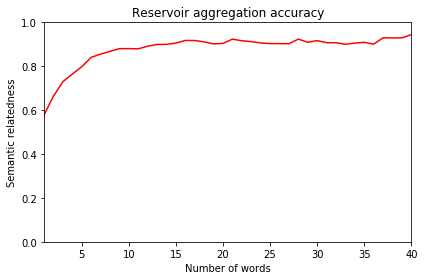

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
t = np.linspace(1, len(discourse_words), len(discourse_words))

ax.set_xlabel('Number of words')
ax.set_ylabel('Semantic relatedness')
ax.set_title(r'Reservoir aggregation accuracy')
ax.set_xlim([1,len(discourse_words)])
ax.set_ylim([0, 1])

ax.plot(t, accuracy_trajectory, color="red")

#ax.legend(loc=0)
fig.tight_layout()
plt.savefig('Exp0-accuracy_trajectory-R1.png', dpi=1200)
plt.show()